In [1]:
!pip install kora -q
from kora import drive
drive.link_nbs()

     |████████████████████████████████| 57 kB 4.9 MB/s 
     |████████████████████████████████| 60 kB 8.1 MB/s 
Mounted at /content/drive


In [2]:
from dataset_generator import getDataset

importing Jupyter notebook from /nbs/dataset_generator.ipynb


Below the train set, train blur set, test set and test blur set is generated

In [3]:
(X_train_Blur,X_train),(X_test_Blur,X_test) = getDataset()

170508288/170498071 [==============================] - 6s 0us/step


Below are the dimensions of the corresponding datasets.
Train blur set : (50000, 32, 32, 3)
train set : (50000, 32, 32, 3)
test set blur: (10000, 32, 32, 3)
test set : (10000, 32, 32, 3)


In [4]:
print(X_train_Blur.shape)
print(X_train.shape)
print(X_test_Blur.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np

# This function displays 10 random images from each of the supplied arrays

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(32, 32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(32, 32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


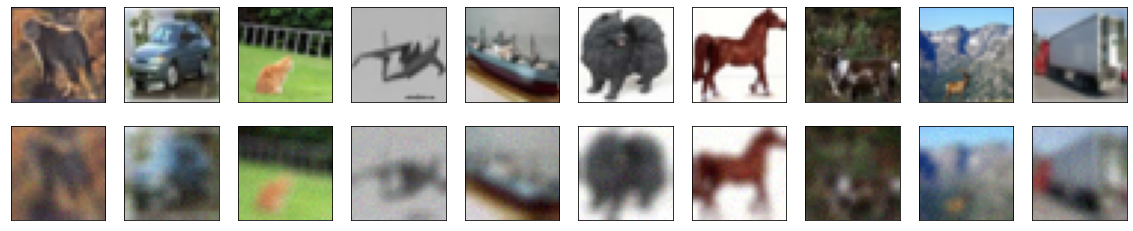

In [6]:
# Display the train data and a version of it with added noise and blur
display(X_train, X_train_Blur)

Below API model actually deblurs the image. The model architecture is taken from DBSR model architecture (more deeper version of DBSRCNN model with extra 3 convolution layers).It has total 8 layers with total parameters 351,043. The first layer consists of 2D convolutions of kernel size=9, number of filters is 32.The ﬁrst layer is feature extraction to compute the low-level features.
The third layer merges features from the ﬁrst twolayers creating a merged vector with low-level and enhanced features.

The merge operation is actually concatenation of 2 previous outputs.

After the concatenation layer, features are processed by 3 more layers before mapping it for final mapping.

https://ieeexplore.ieee.org/document/8903000




In [7]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def DBSRCNN(input_shape,output_shape=None):
  x = layers.Input(shape = input_shape)
  c1 = layers.Convolution2D(64, (9, 9), padding="same", kernel_initializer="he_normal", activation="relu")(x)
  c2 = layers.Convolution2D(32, (5, 5), padding="same", kernel_initializer="he_normal", activation="relu")(c1)
  m=   layers.concatenate([c1, c2])
  c3 = layers.Convolution2D(64, (5, 5), padding="same", kernel_initializer="he_normal", activation="relu")(m)
  c4 = layers.Convolution2D(32, (5, 5), padding="same", kernel_initializer="he_normal", activation="relu")(c3)
  c5 = layers.Convolution2D(32, (5, 5), padding="same", kernel_initializer="he_normal", activation="relu")(c4)
  c6 = layers.Convolution2D(32, (5, 5), padding="same", kernel_initializer="he_normal", activation="relu")(c5)
  c7 = layers.Convolution2D(32, (5, 5), padding="same", kernel_initializer="he_normal", activation="relu")(c6)
  c8 = layers.Convolution2D(3, (5, 5), padding="same", kernel_initializer="he_normal")(c7)
  deblured = Model(inputs = x, outputs = c8)
  return deblured



The below function is the schedular. It helps to update the learning rate of the optimizer while training.

In [8]:
import math

def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.1
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

  

Here we are dynamically updating the learning rate while training. mean squared error loss function is used.

In [9]:
first_model = DBSRCNN((32,32,3))

##compile
first_model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),loss='mean_squared_error', metrics=['mse','accuracy'])

first_model.summary()

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   51232       ['conv2d[0][0]']                 
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 96)   0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]']           

Here we are training the deblurring model with input as blurred train set and output as the x_train set. For validation we are using blurred X test set and X_test set.


In [10]:
hist = first_model.fit(
    x=X_train_Blur,
    y=X_train,
    epochs=70,
    batch_size=64,
    shuffle=True,
    callbacks = [lrate],
    validation_data=(X_test_Blur, X_test))

Epoch 1/70
782/782 [==============================] - 40s 37ms/step - loss: 0.0137 - mse: 0.0137 - accuracy: 0.6907 - val_loss: 0.0047 - val_mse: 0.0047 - val_accuracy: 0.7839 - lr: 0.0010
Epoch 2/70
782/782 [==============================] - 29s 37ms/step - loss: 0.0045 - mse: 0.0045 - accuracy: 0.7740 - val_loss: 0.0050 - val_mse: 0.0050 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 3/70
782/782 [==============================] - 29s 37ms/step - loss: 0.0041 - mse: 0.0041 - accuracy: 0.7895 - val_loss: 0.0037 - val_mse: 0.0037 - val_accuracy: 0.8115 - lr: 0.0010
Epoch 4/70
782/782 [==============================] - 30s 38ms/step - loss: 0.0039 - mse: 0.0039 - accuracy: 0.7962 - val_loss: 0.0038 - val_mse: 0.0038 - val_accuracy: 0.8154 - lr: 0.0010
Epoch 5/70
782/782 [==============================] - 30s 38ms/step - loss: 0.0037 - mse: 0.0037 - accuracy: 0.8029 - val_loss: 0.0035 - val_mse: 0.0035 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 6/70
782/782 [==============================] - 2

weights of deblur model is saved. And a comparison of picture of test blurred set pictures and the predicted pictures of model is shown.

We can observe there is a deblurring of the pictures occured.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


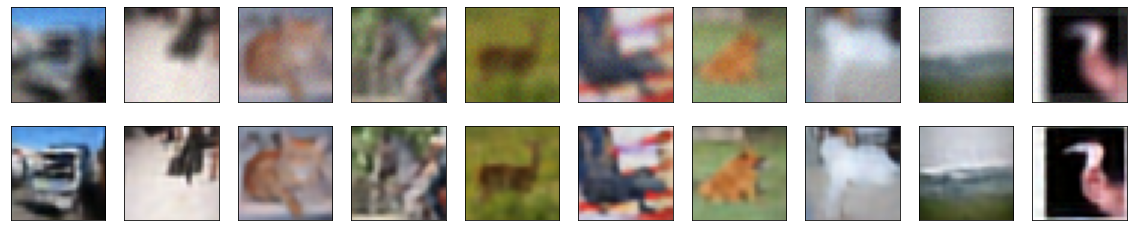

In [11]:
# Saving the model and it weights seperately
first_model.save('/weights/deblur.h5')
first_model.save_weights('/weights/deblur_weight.h5')


predictions = first_model.predict(X_test_Blur)
display(X_test_Blur, predictions)

The mse value of the deblur model is shown below

We can observe that the image quality is improved slightly.

The MSE value of the model is 0.0024

In [12]:
first_model.evaluate(X_test_Blur,X_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.0024 - mse: 0.0024 - accuracy: 0.8575


[0.0024317773059010506, 0.0024317773059010506, 0.8575204014778137]

The mse and loss value curve is shown with train and validation set.
The model is not overfitting or underfitting.

We are plotting the mse , loss and accuracy against the epoch value of the train and validation set

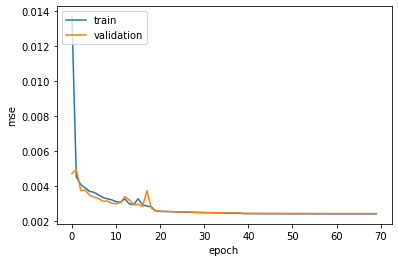

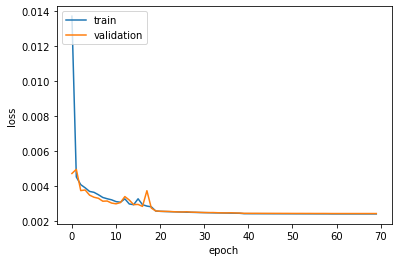

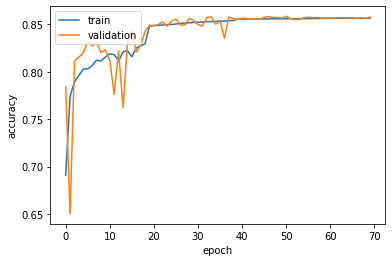

In [13]:
import matplotlib.pyplot as plt

def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_history(hist,['mse','val_mse'])
plot_history(hist,['loss','val_loss'])
plot_history(hist,['accuracy','val_accuracy'])

We can see the model is neither overfitting nor underfitting.

########################------------------------------------############

Below is the model to denoise the image. It is a DnCNN model. It has 19 layers. Total parameters are 561283. 

The idea behind denoising the image : 

let the input image is y which is noisy.
So y = x + v, where x is the denoised image and v is the noise.

So, x = y-v we will get the denoised image.

In the below model, The first layer and the second layer captures the feature of the noisy image, the subsequent 15 Convolutional layers with filter size 3 and number of filters are 64 captures the noise.

The last layer does the subtraction.

https://ieeexplore.ieee.org/document/7839189

In [14]:
from keras.models import load_model
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract
#from tensorflow.keras.callbacks import EarlyStopping


def DnCNN():
    
    inpt = Input(shape=(32,32,3))
    # 1st layer, Conv+relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
    x = Activation('relu')(x)
    # 15 layers, Conv+BN+relu
    for i in range(15):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
        x = Activation('relu')(x)   
    # last layer, Conv
    x = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Subtract()([inpt, x])   # input - noise
    model = Model(inputs=inpt, outputs=x)
    
    return model


denoised = DnCNN()
denoised.summary()
##Compile
denoised.compile(optimizer='adam' , loss='mse', metrics=['mse','accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 64)   36928       ['activation[0][0]']             
                                                                                            

Here we are training the deblurring model with input as blurred train set and output as the x_train set. For validation we are using blurred X test set and X_test set.

In [15]:
denoised.fit(
    x=X_train_Blur,
    y=X_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test_Blur, X_test),
)

Epoch 1/100
1563/1563 [==============================] - 64s 39ms/step - loss: 0.0061 - mse: 0.0061 - accuracy: 0.7690 - val_loss: 0.0037 - val_mse: 0.0037 - val_accuracy: 0.7721
Epoch 2/100
1563/1563 [==============================] - 60s 39ms/step - loss: 0.0033 - mse: 0.0033 - accuracy: 0.7781 - val_loss: 0.0032 - val_mse: 0.0032 - val_accuracy: 0.7773
Epoch 3/100
1563/1563 [==============================] - 60s 39ms/step - loss: 0.0031 - mse: 0.0031 - accuracy: 0.7792 - val_loss: 0.0031 - val_mse: 0.0031 - val_accuracy: 0.7775
Epoch 4/100
1563/1563 [==============================] - 61s 39ms/step - loss: 0.0030 - mse: 0.0030 - accuracy: 0.7792 - val_loss: 0.0030 - val_mse: 0.0030 - val_accuracy: 0.7810
Epoch 5/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.0029 - mse: 0.0029 - accuracy: 0.7794 - val_loss: 0.0033 - val_mse: 0.0033 - val_accuracy: 0.7814
Epoch 6/100
1563/1563 [==============================] - 60s 38ms/step - loss: 0.0028 - mse: 0.0028 - acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


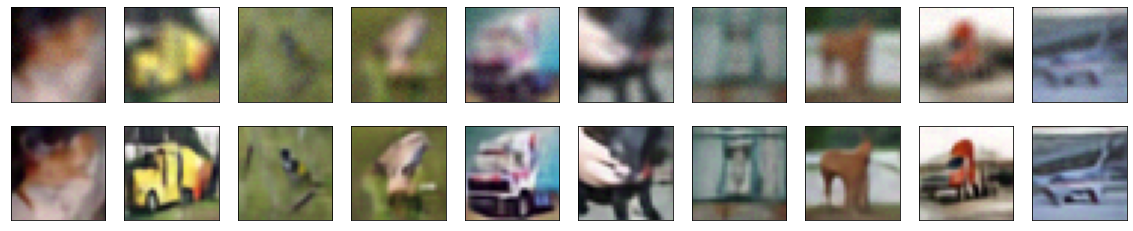

In [16]:
#Saving the weights and the model of the denoising model
denoised.save('/weights/denoise.h5')

denoised.save_weights('/weights/denoise_weights.h5')

predictions = denoised.predict(X_test_Blur)
display(X_test_Blur, predictions)



We can observe that image quality is slightly denoised.

313/313 [==============================] - 4s 12ms/step - loss: 0.0023 - mse: 0.0023 - accuracy: 0.8115


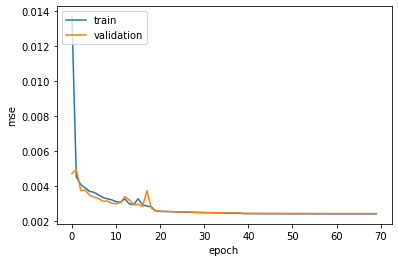

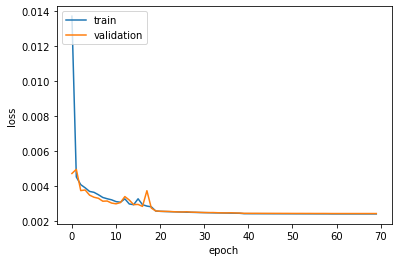

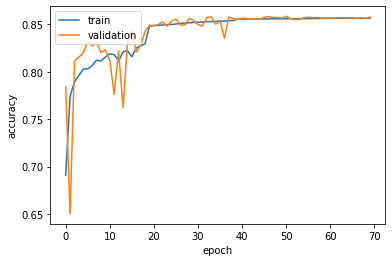

In [17]:
denoised.evaluate(X_test_Blur,X_test)

plot_history(hist,['mse','val_mse'])
plot_history(hist,['loss','val_loss'])
plot_history(hist,['accuracy','val_accuracy'])

We can observe that the DnCNN model is neither overfitting nor underfitting. With mean accuracy 0.86

############---------------###################

Now we have 2 models for deblurring DBSR and denoising DnCNN. 

Let the blurry and noisy image be : h

Therefore, h = I*g + ϵ. where g: is the gaussian blur
                              I: Actual image
                              ϵ: Gaussian noise

Gaussian blur g is convolved with actual image
In the final model h is the input and I should be the expected output.

So first we apply DnCNN. The resulting image should be I*g' where g' is new gaussian blur as denoising causes little bit blurring.

Then we apply, DBSR and we obtain I' as output.

Now we are applying fSRCNN for image restoration as I' is enhanced but contain dark patches.

In [25]:

denoise = load_model('/weights/denoise.h5')
load_first_model = load_model('/weights/deblur.h5')

denoise.trainable = False
load_first_model.trainable = False

input = layers.Input(shape=(32, 32, 3))
x = denoise(input,training = False) 
r = load_first_model(x, training = False)

#concat = layers.Concatenate()([input,r])
# Feature extraction layer.
x = layers.Conv2D(56, (5, 5), padding="same", activation='relu')(r)

# Shrinking layer.
x = layers.Conv2D(12, (1, 1), padding="valid", activation='relu')(x)

# Mapping layer.
#for i in range(3):
x =   layers.Conv2D(12, (3, 3), padding="same")(x)
x =   Activation('relu')(x)
# Expanding layer.
x =  layers.Conv2D(56, (1, 1), padding="valid", activation='relu')(x) 

x = layers.Dropout(0.2)(x)
 # Deconvolution layer.
decoded = layers.Conv2DTranspose(3,(9, 9),padding='same')(x)


model = Model(input, decoded)

model.summary()

model.compile(optimizer=Adam(learning_rate = 0.002),loss='mse',metrics=['mse','accuracy'])


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model_1 (Functional)        (None, 32, 32, 3)         561283    
                                                                 
 model (Functional)          (None, 32, 32, 3)         351043    
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 56)        4256      
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 12)        684       
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 12)        1308      
                                                                 
 activation_18 (Activation)  (None, 32, 32, 12)        0   

In [26]:
hist = model.fit(X_train_Blur,X_train,epochs=50,batch_size=128,shuffle=True,
    validation_data=(X_test_Blur, X_test),)

Epoch 1/50
391/391 [==============================] - 40s 97ms/step - loss: 0.0117 - mse: 0.0117 - accuracy: 0.5754 - val_loss: 0.0044 - val_mse: 0.0044 - val_accuracy: 0.6654
Epoch 2/50
391/391 [==============================] - 37s 94ms/step - loss: 0.0042 - mse: 0.0042 - accuracy: 0.7025 - val_loss: 0.0034 - val_mse: 0.0034 - val_accuracy: 0.7683
Epoch 3/50
391/391 [==============================] - 37s 93ms/step - loss: 0.0036 - mse: 0.0036 - accuracy: 0.7706 - val_loss: 0.0032 - val_mse: 0.0032 - val_accuracy: 0.7909
Epoch 4/50
391/391 [==============================] - 37s 94ms/step - loss: 0.0035 - mse: 0.0035 - accuracy: 0.7772 - val_loss: 0.0031 - val_mse: 0.0031 - val_accuracy: 0.8099
Epoch 5/50
391/391 [==============================] - 37s 94ms/step - loss: 0.0033 - mse: 0.0033 - accuracy: 0.7886 - val_loss: 0.0031 - val_mse: 0.0031 - val_accuracy: 0.8154
Epoch 6/50
391/391 [==============================] - 37s 94ms/step - loss: 0.0032 - mse: 0.0032 - accuracy: 0.7900 - va

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


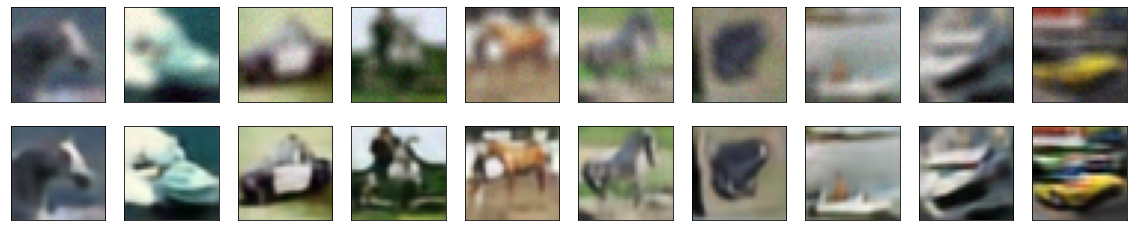

In [27]:
model.save('/weights/final_model.h5')

model.save_weights('/weights/final_model_weights.h5')

predictions = model.predict(X_test_Blur)
display(X_test_Blur,predictions)

In [28]:
model.evaluate(X_test_Blur,X_test)

313/313 [==============================] - 6s 20ms/step - loss: 0.0028 - mse: 0.0028 - accuracy: 0.8068


[0.0028275426011532545, 0.0028275426011532545, 0.8067715764045715]

The final model is not overfitting or underfitting.

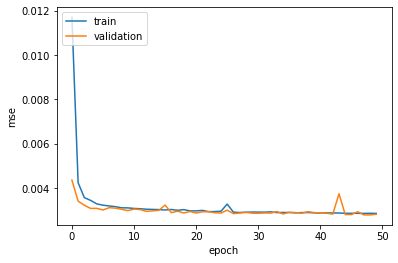

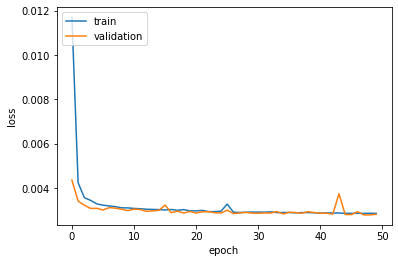

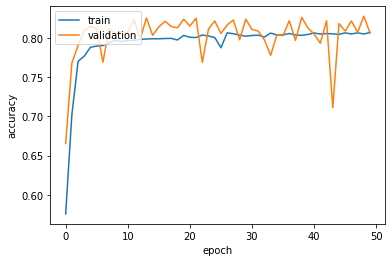

In [29]:
plot_history(hist,['mse','val_mse'])
plot_history(hist,['loss','val_loss'])
plot_history(hist,['accuracy','val_accuracy'])